In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
class MyModel():

    def __init__(self):
        '''
        Crear el modelos para segmentación
        '''
        self.input_rgb = tf.keras.layers.Input(shape=(480,640,3),dtype=tf.float32,name='input_1')
        self.input_depth = tf.keras.layers.Input(shape=(480,640,1),dtype=tf.float32,name='input_2')
        self.fusion_1 = None
        self.fusion_2 = None
        self.fusion_3 = None

    def rgbd_fusion(self,input_r,input_d,capa):
        r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
        r = tf.keras.layers.Reshape((1,1,64*capa))(r)
        r = tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
        r = tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
        m_1 = tf.keras.layers.Multiply()([input_r,r])
        
        d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
        d = tf.keras.layers.Reshape((1,1,64*capa))(d)
        d = tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
        d = tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
        m_2 = tf.keras.layers.Multiply()([input_d,d])
        
        return tf.keras.layers.Add()([m_1,m_2])

    def resnet_layer(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def resnet_layer_div(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same', strides=(2,1))(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same', strides=(1,2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)

        return x
    
    def bottleneck_layer(self,input_bo,filters):
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(input_bo)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_bo])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def decode_layer(self,input_de,input_add,filters):
        x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(input_de)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(x)
        x_2 = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), activation='relu', padding='same')(input_add)
        x = tf.keras.layers.Add()([x, x_2])

        return x
        
    def model(self):

        # Preparar la entrada de datos
        xr = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_rgb)
        xd = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_depth)

        # Fusion
        xr = self.rgbd_fusion(xr,xd,1)

        # Preparar para encoder
        xr = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xr)
        xd = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xd)

        ''' ENCODER'''
        # PRIMERA CAPA
        xr = self.resnet_layer(xr,xr,64)
        xd = self.resnet_layer(xd,xd,64)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,1)
        self.fusion_1 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # SEGUNDA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xr),128)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xd),128)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,128)
            xd = self.resnet_layer(xd,xd,128)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,2)
        self.fusion_2 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # TERCERA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2))(xr),256)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2))(xd),256)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,4)
        self.fusion_3 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # CUARTA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2))(xr),512)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2))(xd),512)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,8)

        '''DECODER'''

        xr = self.decode_layer(xr,self.fusion_3,512)
        xr = self.decode_layer(xr,self.fusion_2,256)
        xr = self.decode_layer(xr,self.fusion_1,128)
        
        xr = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same')(xr)

        return tf.keras.Model(inputs=[self.input_rgb, self.input_depth], outputs=xr)

In [3]:
model = MyModel().model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 320, 64) 3200        input_2[0][0]                    
______________________________________________________________________________________________

In [4]:
tf.keras.utils.plot_model(model,to_file="model.png")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [5]:
import pandas as pd

labels = pd.read_csv('label_names.csv',header=None)
label_names = {}
for i in labels[0]:
    label_names[i.split(';')[0]] = i.split(';')[1].split("'")[1]
num_classes = len(label_names)

In [6]:
from PIL import Image
from pathlib import Path
from nyuv2 import *
from toolbox_nyu_depth_v2 import *
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

DATASET_DIR = Path('dataset')
labeled = LabeledDataset(DATASET_DIR / 'nyu_depth_v2_labeled.mat')
# save_dir = 'segmented'
# color_dir = save_dir + '/color/'
# depth_dir = save_dir + '/depth/'
# label_dir = save_dir + '/label/'

x1 = []
x2 = []
y = []


for i in range(1449): # valor maximo 1449
    color, depth, label = labeled[i]
    
    # x1.append(color)
    # x2.append(depth)
    # y.append(label)

    x1.append(img_to_array(color)/255) 
    x2.append(img_to_array(depth)/255)
    y.append(img_to_array(label))

    # color.save(color_dir + 'r_'+ str(i) +'.png')
    # depth.save(depth_dir + 'd_'+ str(i) +'.png')
    # label.save(label_dir + 'l_'+ str(i) +'.png')

x1 = np.array(x1)
x2 = np.array(x2)
y = np.array(y)



ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [ ]:
print(type(x1[0]))
print(type(x1[0][0][0][0]))
# print(x1.format)
# print(x1.mode)
print(x1[0].size)
print(x1[0].shape)
print(x2[0].shape)
print(y[0].shape)

<class 'numpy.ndarray'>
<class 'numpy.float32'>
921600
(480, 640, 3)
(480, 640, 1)
(480, 640, 1)


In [8]:
x1_train = x1[:1200]
x1_test = x1[1200:]
x2_train = x2[:1200]
x2_test = x2[1200:]
y_train = y[:1200]
y_test = y[1200:]

In [ ]:
# Para guardar dataset
tf.data.experimental.save(tf.data.Dataset.from_tensor_slices(([x1,x2], y)), path='segmented')

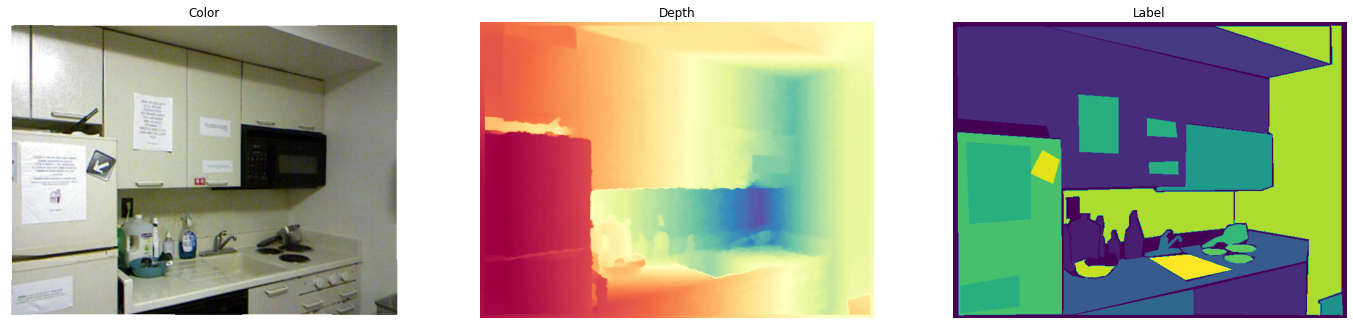

In [9]:
def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

number = 1

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, x1[number])

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, np.asarray(x2[number]))

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, y[number])

plt.show()

In [8]:
# Para guardar dataset
tf.data.experimental.save(tf.data.Dataset.from_tensor_slices(([x1,x2], y)), path='segmented')

In [49]:
# No para guardar dataset
x1_data = tf.data.Dataset.from_tensor_slices(x1)
x2_data = tf.data.Dataset.from_tensor_slices(x2)
y_data = tf.data.Dataset.from_tensor_slices(y)

In [10]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [12]:
# miou = tf.keras.metrics.MeanIoU(num_classes, name=None, dtype=None)

model.compile(loss="sparse_categorical_crossentropy", optimizer= "Adam", metrics =["accuracy"])

# Para utilizar el 20% para validación vamos a poner que realizen un split de 0,2
history = model.fit({'input_1': x1_train, 'input_2': x2_train}, y_train, epochs=30, verbose=1, batch_size=64, validation_split=0.2)

Epoch 1/30


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor of shape [64,32,480,640] and type float
	 [[{{node gradient_tape/sparse_categorical_crossentropy/clip_by_value/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer}}]]
  (1) Cancelled:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_27420]

Function call stack:
train_function -> train_function


In [ ]:
plot_acc(history)
plot_loss(history)